# Assignment 5
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se
***

### Preliminaries
***

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar  3 18:58:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# Import libaries
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.resnet import ResNet50_Weights

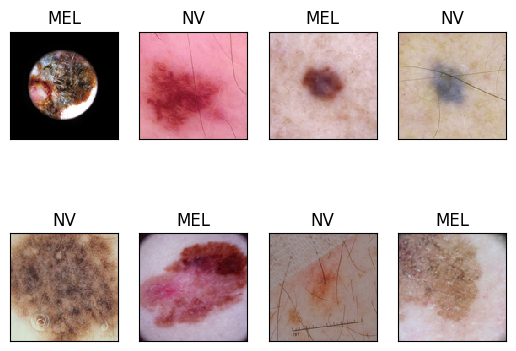

In [5]:
folder = ImageFolder('/content/drive/MyDrive/Colab Notebooks/a5_data/train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(loader))

for i in range(8):
    plt.subplot(2,4,i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

### Apply the these techniques:
- some sort of normalization such as batch normalization, layer normalization, or group normalization,
- residual connections,
- data augmentation by applying random transformations to the images,
- transfer learning using a pre-trained model (see below for some hints).

### Exploring the efficiency of ResNET50 and ResNET18 on detecting skin cancer

### Task 1: Preprocessing
***

In [6]:
def count_files(path):
    return sum([len(files) for r, d, files in os.walk(path)])


# Paths for MEL and NV
train_path_MEL= '/content/drive/MyDrive/Colab Notebooks/a5_data/train/MEL'
train_path_NV= '/content/drive/MyDrive/Colab Notebooks/a5_data/train/NV'

val_path_MEL= '/content/drive/MyDrive/Colab Notebooks/a5_data/val/MEL'
val_path_NV= '/content/drive/MyDrive/Colab Notebooks/a5_data/val/NV'

test_blind_path = '/content/drive/MyDrive/Colab Notebooks/a5_data/test_blind/blind'

# Paths to train and val
train_path = '/content/drive/MyDrive/Colab Notebooks/a5_data/train'
val_path = '/content/drive/MyDrive/Colab Notebooks/a5_data/val'

print('**training set**')
print('MEL:', count_files(train_path_MEL))
print('NV:', count_files(train_path_NV))

print('**validation set**')
print('MEL:', count_files(val_path_MEL))
print('NV:', count_files(val_path_NV))

print('**test set**')
print('TOTAL:', count_files(test_blind_path ))

**training set**
MEL: 3213
NV: 3213
**validation set**
MEL: 626
NV: 626
**test set**
TOTAL: 1366


In [ ]:
def calculate_average_image_dimensions(folder_path):
    # List of common image extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Initialize variables to store total width, total height, and count of images
    total_width = 0
    total_height = 0
    image_count = 0

    # Iterate through each file in the folder
    for file in os.listdir(folder_path):
        if Path(file).suffix.lower() in image_extensions:
            try:
                # Open the image and get its dimensions
                file_path = os.path.join(folder_path, file)
                with Image.open(file_path) as img:
                    width, height = img.size
                    total_width += width
                    total_height += height
                    image_count += 1
            except Exception as e:
                print(f"Error processing {file}: {e}")

    # Calculate the average dimensions
    average_width = total_width / image_count if image_count else 0
    average_height = total_height / image_count if image_count else 0

    return average_width, average_height


print('Average dimensions of training images with melenoma:', calculate_average_image_dimensions(train_path_MEL))
print('Average dimensions of training images without melenoma:', calculate_average_image_dimensions(train_path_NV))

Average dimensions of training images with melenoma: (128.0, 128.0)
Average dimensions of training images without melenoma: (128.0, 128.0)


In [7]:
torch.manual_seed(42)

# Define transformations for the training data and validation data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    # Add ColorJitter for brightness, contrast, saturation, and hue adjustments
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize images
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize images
                         std=[0.229, 0.224, 0.225])
])


# Load datasets
train_folder = ImageFolder(train_path, transform=train_transforms)
val_folder = ImageFolder(val_path, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_folder, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_folder, batch_size=32, shuffle=False, num_workers=2)


In [8]:
print("Training dataset classes and their indices:", train_folder.class_to_idx)
print("Validation dataset classes and their indices:", val_folder.class_to_idx)

Training dataset classes and their indices: {'MEL': 0, 'NV': 1}
Validation dataset classes and their indices: {'MEL': 0, 'NV': 1}


In [ ]:
# Load a pre-trained ResNet-50 model with updated syntax
weights = ResNet50_Weights.IMAGENET1K_V1  # This is equivalent to the previous pretrained=True
model = models.resnet50(weights=weights)

# Freeze all the parameters in the model to prevent them from being updated during training
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# ResNet-50's last layer's input features
num_ftrs = model.fc.in_features
# Change the final layer to match the number of classes (2 in your case)
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Cross-Entropy Loss function for two classes
criterion = nn.CrossEntropyLoss()

# Optimizer that will update the parameters of the last layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
def train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, epochs=25, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    epoch_loss_history = []
    epoch_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        epoch_loss_history.append(epoch_loss)
        epoch_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        print(f'Epoch {epoch}/{epochs - 1} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Stopping early at epoch {epoch} due to no improvement in validation loss.')
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_history, epoch_acc_history, val_loss_history, val_acc_history

In [ ]:
# Train the model with early stopping
model_trained, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, epochs=25, patience=5)

Epoch 0/24 - Loss: 0.4546 - Acc: 0.7779 - Val Loss: 0.4050 - Val Acc: 0.8019
Epoch 1/24 - Loss: 0.4064 - Acc: 0.8103 - Val Loss: 0.3358 - Val Acc: 0.8411
Epoch 2/24 - Loss: 0.3947 - Acc: 0.8140 - Val Loss: 0.3340 - Val Acc: 0.8387
Epoch 3/24 - Loss: 0.3792 - Acc: 0.8271 - Val Loss: 0.3391 - Val Acc: 0.8395
Epoch 4/24 - Loss: 0.3710 - Acc: 0.8279 - Val Loss: 0.3822 - Val Acc: 0.8347
Epoch 5/24 - Loss: 0.3844 - Acc: 0.8218 - Val Loss: 0.3787 - Val Acc: 0.8419
Epoch 6/24 - Loss: 0.3637 - Acc: 0.8340 - Val Loss: 0.3277 - Val Acc: 0.8530
Epoch 7/24 - Loss: 0.3530 - Acc: 0.8430 - Val Loss: 0.3224 - Val Acc: 0.8506
Epoch 8/24 - Loss: 0.3739 - Acc: 0.8299 - Val Loss: 0.3203 - Val Acc: 0.8586
Epoch 9/24 - Loss: 0.3722 - Acc: 0.8326 - Val Loss: 0.3842 - Val Acc: 0.8371
Epoch 10/24 - Loss: 0.3606 - Acc: 0.8308 - Val Loss: 0.3306 - Val Acc: 0.8419
Epoch 11/24 - Loss: 0.3619 - Acc: 0.8375 - Val Loss: 0.3235 - Val Acc: 0.8450
Epoch 12/24 - Loss: 0.3521 - Acc: 0.8428 - Val Loss: 0.3145 - Val Acc: 0.8

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/melanoma_classification_modelv100_1.pth')

#Model 2

In [ ]:
# Load a pre-trained ResNet-50 model with updated syntax
weights = ResNet50_Weights.IMAGENET1K_V1  # This is equivalent to the previous pretrained=True
model = models.resnet50(weights=weights)

# Freeze all the parameters in the model to prevent them from being updated during training
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# ResNet-50's last layer's input features
num_ftrs = model.fc.in_features
# Change the final layer to match the number of classes (2 in your case)
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Unfreeze the last two layers
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True

optimizer = optim.SGD([
    {'params': model.layer4.parameters(), 'lr': 1e-4, 'momentum': 0.9},
    {'params': model.layer3.parameters(), 'lr': 1e-4, 'momentum': 0.9},
    {'params': model.fc.parameters(), 'lr': 1e-3, 'momentum': 0.9}  # Possibly higher lr for the last layer
], lr=1e-4, momentum=0.9)  # Default lr and momentum for all other parameters

# Define your criterion
criterion = torch.nn.CrossEntropyLoss()

# If using a learning rate scheduler, define it here
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
def train_model_with_early_stopping(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=25, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    epoch_loss_history = []
    epoch_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        epoch_loss_history.append(epoch_loss)
        epoch_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        print(f'Epoch {epoch}/{epochs - 1} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}')

        scheduler.step()  # Adjust the learning rate based on the scheduler

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Stopping early at epoch {epoch} due to no improvement in validation loss.')
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_history, epoch_acc_history, val_loss_history, val_acc_history


In [ ]:
# Training
model_trained, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model_with_early_stopping(
    model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=25, patience=5
)

Epoch 0/24 - Loss: 0.4579 - Acc: 0.7652 - Val Loss: 0.3386 - Val Acc: 0.8387
Epoch 1/24 - Loss: 0.3760 - Acc: 0.8256 - Val Loss: 0.3348 - Val Acc: 0.8347
Epoch 2/24 - Loss: 0.3557 - Acc: 0.8332 - Val Loss: 0.3036 - Val Acc: 0.8578
Epoch 3/24 - Loss: 0.3281 - Acc: 0.8517 - Val Loss: 0.3065 - Val Acc: 0.8714
Epoch 4/24 - Loss: 0.3165 - Acc: 0.8589 - Val Loss: 0.2907 - Val Acc: 0.8610
Epoch 5/24 - Loss: 0.3191 - Acc: 0.8515 - Val Loss: 0.2947 - Val Acc: 0.8810
Epoch 6/24 - Loss: 0.3108 - Acc: 0.8624 - Val Loss: 0.2966 - Val Acc: 0.8578
Epoch 7/24 - Loss: 0.2937 - Acc: 0.8705 - Val Loss: 0.2841 - Val Acc: 0.8674
Epoch 8/24 - Loss: 0.2915 - Acc: 0.8680 - Val Loss: 0.2780 - Val Acc: 0.8730
Epoch 9/24 - Loss: 0.2940 - Acc: 0.8724 - Val Loss: 0.3077 - Val Acc: 0.8730
Epoch 10/24 - Loss: 0.2771 - Acc: 0.8797 - Val Loss: 0.2835 - Val Acc: 0.8842
Epoch 11/24 - Loss: 0.2720 - Acc: 0.8814 - Val Loss: 0.2860 - Val Acc: 0.8842
Epoch 12/24 - Loss: 0.2762 - Acc: 0.8805 - Val Loss: 0.2779 - Val Acc: 0.8

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/melanoma_classification_modelv100_2.pth')


# Model Evaluation

In [9]:
# Load the model

# Step 1: Recreate the model setup
weights = ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)

# Freeze all the parameters (they are frozen by default in this setup, but this is how you would manually freeze them)
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Adjust for the number of classes

# Unfreeze the last two layers
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True

# Step 2: Load the trained model weights
model_path = '/content/drive/MyDrive/Colab Notebooks/melanoma_classification_modelv100_2.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Step 3: Prepare the model for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
from PIL import Image
import pandas as pd


# Define the transformation applied to test images
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load images without labels
def load_unlabeled_images(image_directory, transform):
    images = []
    filenames = []
    for img_path in Path(image_directory).glob('*.png'):  # Adjust pattern if necessary
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        images.append(img)
        filenames.append(img_path.name)
    return torch.stack(images), filenames

# Load test images
test_images, test_filenames = load_unlabeled_images(test_blind_path, test_transforms)
test_loader = DataLoader(test_images, batch_size=32, shuffle=False)

def predict(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

# Assuming your model is already loaded and moved to the appropriate device
predictions = predict(model, test_loader, device)

# Map numerical predictions back to class names (adjust as necessary)
class_names = {0: 'MEL', 1: 'NV'}
predicted_labels = [class_names[pred] for pred in predictions]

# Optionally, save predictions to CSV
prediction_df = pd.DataFrame({'Filename': test_filenames, 'Prediction': predicted_labels})
prediction_df.to_csv('/content/drive/MyDrive/Colab Notebooks/test_predictions.csv', index=False)


### References
***
- Anand, V., Gupta, S., Soumya Ranjan Nayak, Deepika Koundal, Prakash, D. and Verma, K.D. (2022). An automated deep learning models for classification of skin disease using Dermoscopy images: a comprehensive study. Multimedia Tools and Applications, [online] 81(26), pp.37379–37401. doi:https://doi.org/10.1007/s11042-021-11628-y.

‌